In [2]:
import cv2
import os
import kagglehub
import pandas as pd
import shutil
import tensorflow as tf
import numpy as np
from datasets import load_dataset
import random
import glob
import matplotlib.pyplot as plt

c:\Graduate_School\Fall_2025\ECE528\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the North American Prediator Dataset

In [2]:
current_directory = os.getcwd()

# Download latest version and move to current directory
path = kagglehub.dataset_download("edenbenson/north-american-predator-dataset")
target_dir = os.path.join(current_directory, "data/north_american_predators")
os.makedirs(target_dir, exist_ok=True)

print("Path to dataset files:", path)
#Downloads dataset from kaggle and copies the files to the current directory
for item in os.listdir(path):
    src = os.path.join(path, item)
    dst = os.path.join(target_dir, item)
    if os.path.isdir(src):
        shutil.copytree(src, dst, dirs_exist_ok=True)
    else:
        shutil.copy2(src, dst)

Path to dataset files: C:\Users\kingk\.cache\kagglehub\datasets\edenbenson\north-american-predator-dataset\versions\3


# Load the Human vs Non-Human Dataset

In [ ]:
ds = load_dataset("prithivMLmods/Human-vs-NonHuman")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 15635
    })
})


In [ ]:
#Downsample and Grey Scale the Human Images
base_dir = "human_nonhuman_dataset"
save_path = r'C:\Graduate_School\Fall_2025\ECE528\Final_Project\data\human_nonhuman_dataset'
output_dir = r'C:\Graduate_School\Fall_2025\ECE528\Final_Project\Final_Project_Models\data\north_american_predators\greyscale_downsampled'

class_map = {0: "human", 1: "non_human"}
target_size = (224, 224)
# Move the images into the same directory with the other classes
for cls in class_map.values():
    os.makedirs(os.path.join(save_path, cls), exist_ok=True)

os.makedirs(os.path.join(output_dir, "human"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "non_human"), exist_ok=True)
for index, img in enumerate(ds["train"]):
    label = img["label"]
    img_original = img["image"]

    img_rgb = cv2.cvtColor(np.array(img_original), cv2.COLOR_RGB2BGR)
    #Greyscale
    grey = cv2.cvtColor(np.array(img_rgb), cv2.COLOR_BGR2GRAY)
    #Downsample
    img_resized = cv2.resize(grey, target_size, cv2.INTER_LANCZOS4)
    cls_name = label
    filename = f"{index:06d}.jpg"
    save_path_modified = os.path.join(output_dir, class_map[cls_name], filename)
    cv2.imwrite(save_path_modified, img_resized)


In [ ]:
#Downsample and Grey Scale the Predator Images

input_dir = "data/north_american_predators/resized"
output_dir = "data/north_american_predators/greyscale_downsampled"

target_size = (224, 224)
#Opens each image and performs preprocessing
for cls in os.listdir(input_dir):
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)
    
    for filename in os.listdir(os.path.join(input_dir, cls)):
        img = cv2.imread(os.path.join(input_dir, cls, filename))
        #Downsample
        img = cv2.resize(img, target_size, cv2.INTER_LANCZOS4)
        #Greyscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(os.path.join(output_dir, cls, filename), gray)


# Resize images to fit the pre-trained models

In [ ]:
input_dir = "C:\Graduate_School\Fall_2025\ECE528\Final_Project\data\original_images"
output_dir = "data/north_american_predators/original_downsampled"

target_size = (224, 224)
#Opens each image and performs preprocessing
for cls in os.listdir(input_dir):
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)
    
    for filename in os.listdir(os.path.join(input_dir, cls)):
        img = cv2.imread(os.path.join(input_dir, cls, filename))
        #Downsample
        img = cv2.resize(img, target_size, cv2.INTER_LANCZOS4)
        cv2.imwrite(os.path.join(output_dir, cls, filename), img)

# Splits the original data into training, validation and test folders

In [ ]:

random.seed(42)

current_folder = r"\original_downsampled"
dir = r"C:\Graduate_School\Fall_2025\ECE528\Final_Project\Final_Project_Models\data\north_american_predators"
dataset_dir = dir + current_folder
test_dir = dataset_dir +  r"_split" + r"\test"
val_dir = dataset_dir +  r"_split" + r"\val"
train_dir = dataset_dir +  r"_split" + r"\train"

test_split = 0.2
val_split = 0.2

try:
    os.mkdir(dir + current_folder + r"_split")
except FileExistsError:
    print("File Already Exists")
os.chdir(dir + current_folder + r"_split")

try:
    os.mkdir(test_dir)
except FileExistsError:
    print("File Already Exists")
try:
    os.mkdir(train_dir)
except FileExistsError:
    print("File Already Exists")
try:
    os.mkdir(val_dir)
except FileExistsError:
    print("File Already Exists")

#Loop over each class
for cls_folder in glob.glob(dataset_dir+r"/" +"*"):
    class_name = os.path.basename(cls_folder)
    print(class_name)
    images = list(glob.glob(cls_folder+r"/" +"*"))
    print("Total Images",len(images))

    n_test = max(1, int(len(images) * test_split))
    test_images = images[:n_test]
    leftover_imgs = images[n_test:]

    n_val = max(1, int(len(leftover_imgs) * val_split))
    val_images = leftover_imgs[:n_val]
    train_images = leftover_imgs[n_val:]
    print("Train:", len(train_images), "Validation:", len(val_images), "Test:", len(test_images))
    # Create class folders
    for subdir in [train_dir, val_dir, test_dir]:
        os.makedirs(subdir + '/'+ class_name, exist_ok=True)
    #Copy Files over
    for img in test_images:
        shutil.copy(img, test_dir + '/' + class_name + '/' + os.path.basename(img))
    for img in val_images:
        shutil.copy(img, val_dir + '/' + class_name + '/' + os.path.basename(img))
    for img in train_images:
        shutil.copy(img, train_dir + '/' + class_name + '/' + os.path.basename(img))

black_bear
Total Images 1000
Train: 640 Validation: 160 Test: 200
brown_bear
Total Images 1000
Train: 640 Validation: 160 Test: 200
cougar
Total Images 999
Train: 640 Validation: 160 Test: 199
coyote
Total Images 960
Train: 615 Validation: 153 Test: 192
human
Total Images 6646
Train: 4254 Validation: 1063 Test: 1329
non_human
Total Images 8989
Train: 5754 Validation: 1438 Test: 1797
polar_bear
Total Images 1000
Train: 640 Validation: 160 Test: 200
wolf
Total Images 1000
Train: 640 Validation: 160 Test: 200


# Splits the greyscale data into training, validation and test folders

In [ ]:
random.seed(42)

current_folder = r"\greyscale_downsampled"
dir = r"C:\Graduate_School\Fall_2025\ECE528\Final_Project\Final_Project_Models\data\north_american_predators"
dataset_dir = dir + current_folder
test_dir = dataset_dir +  r"_split" + r"\test"
val_dir = dataset_dir +  r"_split" + r"\val"
train_dir = dataset_dir +  r"_split" + r"\train"

test_split = 0.2
val_split = 0.2

try:
    os.mkdir(dir + current_folder + r"_split")
except FileExistsError:
    print("File Already Exists")
os.chdir(dir + current_folder + r"_split")

try:
    os.mkdir(test_dir)
except FileExistsError:
    print("File Already Exists")
try:
    os.mkdir(train_dir)
except FileExistsError:
    print("File Already Exists")
try:
    os.mkdir(val_dir)
except FileExistsError:
    print("File Already Exists")

#Loop over each class
for cls_folder in glob.glob(dataset_dir+r"/" +"*"):
    class_name = os.path.basename(cls_folder)
    print(class_name)
    images = list(glob.glob(cls_folder+r"/" +"*"))
    print("Total Images",len(images))

    n_test = max(1, int(len(images) * test_split))
    test_images = images[:n_test]
    leftover_imgs = images[n_test:]

    n_val = max(1, int(len(leftover_imgs) * val_split))
    val_images = leftover_imgs[:n_val]
    train_images = leftover_imgs[n_val:]
    print("Train:", len(train_images), "Validation:", len(val_images), "Test:", len(test_images))
    # Create class folders
    for subdir in [train_dir, val_dir, test_dir]:
        os.makedirs(subdir + '/'+ class_name, exist_ok=True)
    #Copy Files over
    for img in test_images:
        shutil.copy(img, test_dir + '/' + class_name + '/' + os.path.basename(img))
    for img in val_images:
        shutil.copy(img, val_dir + '/' + class_name + '/' + os.path.basename(img))
    for img in train_images:
        shutil.copy(img, train_dir + '/' + class_name + '/' + os.path.basename(img))

black_bear
Total Images 1000
Train: 640 Validation: 160 Test: 200
brown_bear
Total Images 1000
Train: 640 Validation: 160 Test: 200
cougar
Total Images 999
Train: 640 Validation: 160 Test: 199
coyote
Total Images 960
Train: 615 Validation: 153 Test: 192
human
Total Images 6646
Train: 4254 Validation: 1063 Test: 1329
non_human
Total Images 8989
Train: 5754 Validation: 1438 Test: 1797
polar_bear
Total Images 1000
Train: 640 Validation: 160 Test: 200
wolf
Total Images 1000
Train: 640 Validation: 160 Test: 200


# Loads all the images to visualize them

Found 21594 files belonging to 8 classes.
['black_bear', 'brown_bear', 'cougar', 'coyote', 'human', 'non_human', 'polar_bear', 'wolf']


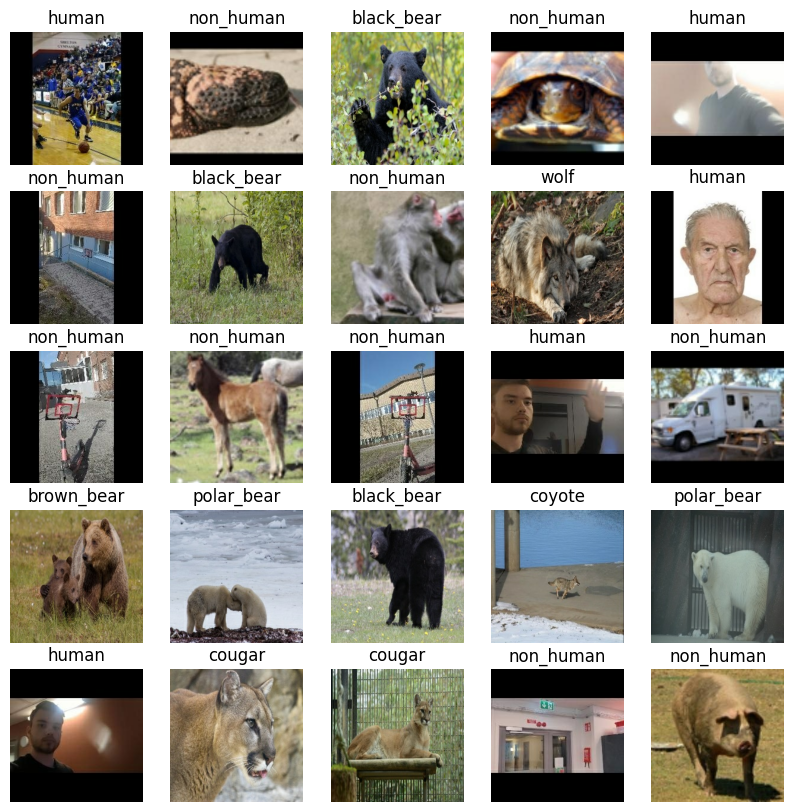

In [10]:
data_dir = r"C:\Graduate_School\Fall_2025\ECE528\Final_Project\Final_Project_Models\data\north_american_predators\original_downsampled"
dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=143,
  image_size=(224, 224),
  batch_size=64)
print(dataset.class_names)
class_names = dataset.class_names
plt.figure(figsize=(10, 10))

for images, labels in dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

Found 21594 files belonging to 8 classes.
['black_bear', 'brown_bear', 'cougar', 'coyote', 'human', 'non_human', 'polar_bear', 'wolf']


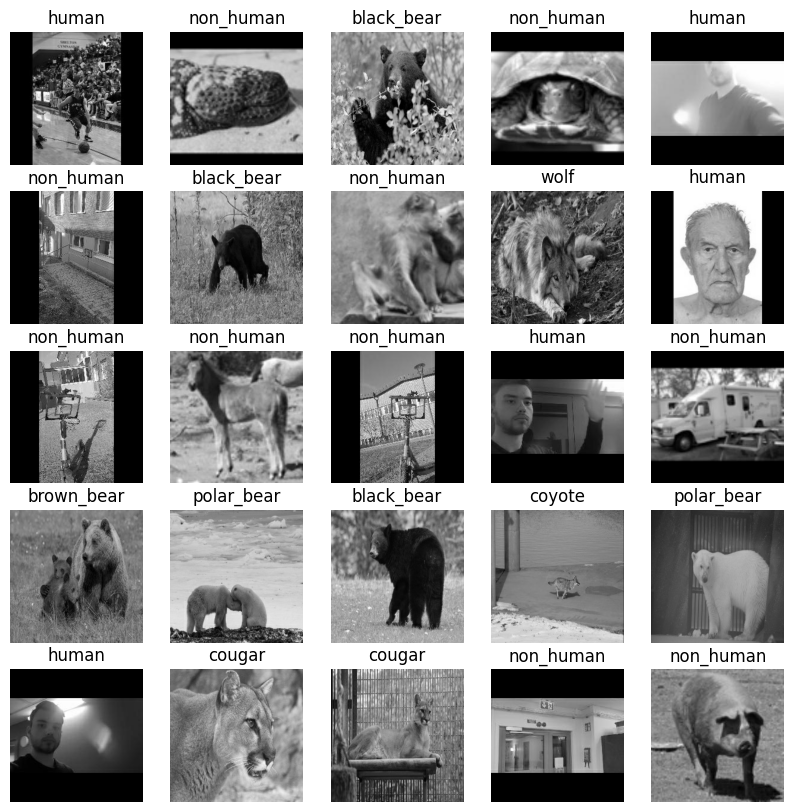

In [ ]:
data_dir = r"C:\Graduate_School\Fall_2025\ECE528\Final_Project\Final_Project_Models\data\north_american_predators\greyscale_downsampled"
dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=143,
  image_size=(224, 224),
  batch_size=64)
print(dataset.class_names)
class_names = dataset.class_names
plt.figure(figsize=(10, 10))

for images, labels in dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()